Patrick Riley

September 2024

This notebook is examining why ROCS vs docking seem to perform differently for Thompson Sampling.

[In our original paper](https://doi.org/10.1021/acs.jcim.3c01790), we noticed that to get good performance for docking we had to search a larger fraction of the library (~1% vs. 0.1%).

Why is this?

This notebook is not runnable publicly because it relies on sqlite files of the complete enumeration for ROCS and docking that we have not released.

In [230]:
import collections
import heapq
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import sqlitedict

In [262]:
import scipy.stats
import scipy.special
import seaborn as sns

# Load data

In [4]:
!ls /data/ts

INPUTS	rocs_scores.sqlite  scores_names_fixed.sqlite  ts_inputs.tar.gz


In [180]:
DATA_DIR = "/data/ts"

In [21]:
db_rocs = sqlitedict.SqliteDict("/data/ts/rocs_scores.sqlite")
db_docking = sqlitedict.SqliteDict("/data/ts/scores_names_fixed.sqlite")

In [23]:
for i, (k, v) in enumerate(db_rocs.items()):
    print(k, v)
    if i > 15:
        break

m_22bbh_57650_6441672 0.7
m_22bbh_57650_6442108 0.77
m_22bbh_57650_6442238 0.69
m_22bbh_57650_6442676 0.9
m_22bbh_57650_6463804 0.83
m_22bbh_57650_6463806 0.97
m_22bbh_57650_6463808 0.96
m_22bbh_57650_6463810 0.66
m_22bbh_57650_6463822 0.74
m_22bbh_57650_6463824 0.96
m_22bbh_57650_6463826 0.85
m_22bbh_57650_6463836 0.92
m_22bbh_57650_6463838 0.71
m_22bbh_57650_6463840 0.78
m_22bbh_57650_6463854 0.94
m_22bbh_57650_6464668 0.74
m_22bbh_57650_6464788 0.88


# Utilities 

In [27]:
def parse_mol(mol):
    """Parse a molecule name into a reaction and list of reagents."""
    # skip the first two chars because an underscore is in the reaction name
    end_reac_idx = mol.index("_", 2)
    reac = mol[0:end_reac_idx]
    reagents = [int(x) for x in mol[end_reac_idx+1:].split("_")]
    return reac, reagents
print(parse_mol("m_22bbh_57650_6464788"))
print(parse_mol("m_22bbh_57650_6464788_65646"))

('m_22bbh', [57650, 6464788])
('m_22bbh', [57650, 6464788, 65646])


In [146]:
class RunningDistributionStats:
    """Efficiently keep track of distribution statistics a variable.

    Keep separate count, mean, and variance without storing all values using
    Welford's algorithm.
    """

    def __init__(self):
        self._counts = 0
        self._nan_counts = 0
        self._means = 0
        self._squared_diffs = 0
        self._stdevs = 0
        self._mins = np.nan
        self._maxs = np.nan

    def update(self, value: float):
        if np.isnan(value):
            self._nan_counts += 1
            return
        self._counts += 1
        delta = value - self._means
        self._means += delta / self._counts
        delta2 = value - self._means
        self._squared_diffs += delta * delta2
        if self._counts == 1:
            self._stdevs = np.sqrt(self._squared_diffs)
        else:
            self._stdevs = np.sqrt(self._squared_diffs / (self._counts - 1))
        if np.isnan(self._mins) or value < self._mins:
            self._mins = value
        if np.isnan(self._maxs) or value > self._maxs:
            self._maxs = value

    def count(self) -> int:
        return self._counts

    def nan_count(self) -> int:
        return self._nan_counts
         
    def mean(self) -> float:
        return self._means

    def stdev(self) -> float:
        return self._stdevs

    def min(self) -> float:
        return self._mins

    def max(self) -> float:
        return self._maxs

    def __str__(self):
        return f"RunningDistributionStats(count={self._counts} nan_count={self._nan_counts} mean={self._means} stdev={self._stdevs} min={self._mins} max={self._maxs})"


Test RunningDistributionStats

In [148]:
rng = np.random.default_rng()
test_data = np.random.gamma(5, 1, 50)
stats = RunningDistributionStats()
for x in test_data:
    stats.update(x)
stats.update(np.nan)
stats.update(np.nan)
print("True: ", test_data.shape, ", Running: ", stats.count())
print("True: ", np.mean(test_data), ", Running: ", stats.mean())
print("True: ", np.std(test_data, ddof=1), ", Running: ", stats.stdev())
print("True: ", np.min(test_data), ", Running: ", stats.min())
print("True: ", np.max(test_data), ", Running: ", stats.max())
print("NaN count: ", stats.nan_count())
print(stats)

True:  (50,) , Running:  50
True:  4.58512590532453 , Running:  4.58512590532453
True:  2.231133562279515 , Running:  2.2311335622795156
True:  1.8418381089137745 , Running:  1.8418381089137745
True:  10.568155787230863 , Running:  10.568155787230863
NaN count:  2
RunningDistributionStats(count=50 nan_count=2 mean=4.58512590532453 stdev=2.2311335622795156 min=1.8418381089137745 max=10.568155787230863)


In [141]:
def collect_stats(db, nan_value=-500.0, top_n=1000, limit=None):
    # A dictionary keyed by reaction name 
    # to a dictionary keyed by cycle 
    # to a dictionary keyed by reagent 
    # to RunningDistributionStats
    overall_stats = RunningDistributionStats()
    reagent_stats = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(RunningDistributionStats)))
    top_vals = []
    for db_idx, (mol, val) in enumerate(db.items()):
        try:
            reac, reagents = parse_mol(mol)
        except ValueError:
            print(f"Failed to parse: '{mol}'")
            continue

        if val == nan_value:
            val = np.nan

        if len(top_vals) == top_n:
            heapq.heappushpop(top_vals, (val, mol))
        else:
            heapq.heappush(top_vals, (val, mol))
            
        overall_stats.update(val)
        
        for cycle, reagent in enumerate(reagents):
            reagent_stats[reac][cycle][reagent].update(val)

        if limit is not None and db_idx >= limit:
            break

    return overall_stats, reagent_stats, top_vals, 

In [142]:
def stats_dict_to_dataframe(all_stats):
    data = collections.defaultdict(list)
    for reac, cycle_dict in all_stats.items():
        for cycle, reagent_dict in cycle_dict.items():
            for reagent, stats in reagent_dict.items():
                data["reaction"].append(reac)
                data["cycle"].append(cycle)
                data["reagent"].append(reagent)
                data["count"].append(stats.count())
                data["nan_count"].append(stats.nan_count())
                data["mean"].append(stats.mean())
                data["stdev"].append(stats.stdev())
                data["min"].append(stats.min())
                data["max"].append(stats.max())
    return pd.DataFrame(data)

# Collect statistics by running over the full enumeration and recording stats

In [159]:
%%time
stats_rocs, stats_reagents_rocs, top_rocs = collect_stats(db_rocs)

Failed to parse: 'm_22bbh_19895766_208m_22bbh_19895766_20854034'
CPU times: user 58min 47s, sys: 6min 46s, total: 1h 5min 33s
Wall time: 1h 2min 10s


In [173]:
print(stats_rocs)

RunningDistributionStats(count=229316728 nan_count=0 mean=0.8310162212412252 stdev=0.12315986442410906 min=0.33 max=1.94)


In [212]:
top_rocs = sorted(top_rocs, reverse=True)
top_rocs[:20]

[(1.94, 'm_22bbh_9285796_9705422'),
 (1.93, 'm_22bbh_9285796_581944'),
 (1.93, 'm_22bbh_9285796_15771828'),
 (1.92, 'm_22bbh_9285796_9600292'),
 (1.92, 'm_22bbh_9285796_134453'),
 (1.91, 'm_22bbh_9285796_9705438'),
 (1.91, 'm_22bbh_9285796_6361394'),
 (1.91, 'm_22bbh_9285796_134455'),
 (1.9, 'm_22bbh_9285796_9650224'),
 (1.9, 'm_22bbh_9285796_134454'),
 (1.89, 'm_22bbh_9285796_9631824'),
 (1.89, 'm_22bbh_9285796_14950570'),
 (1.89, 'm_22bbh_9285796_14940890'),
 (1.89, 'm_22bbh_9285796_13160038'),
 (1.88, 'm_22bbh_9403780_581944'),
 (1.88, 'm_22bbh_9403780_15771828'),
 (1.88, 'm_22bbh_9285796_9478620'),
 (1.88, 'm_22bbh_9285796_9229000'),
 (1.88, 'm_22bbh_9285796_20885438'),
 (1.87, 'm_22bbh_9403780_9705438')]

In [192]:
df_stats_reagents_rocs = stats_dict_to_dataframe(stats_reagents_rocs)

In [103]:
db_rocs["m_22bbh_19895766_208m_22bbh_19895766_20854034"]

0.59

One bad entry in the DB that we'll just ignore.

In [ ]:
%%time
stats_docking, stats_reagents_docking, top_docking = collect_stats(db_docking)

In [170]:
print(stats_docking)

RunningDistributionStats(count=330296051 nan_count=529616 mean=6.714249918082733 stdev=1.0228285118245632 min=0.0 max=14.73)


In [213]:
top_docking = sorted(top_docking, reverse=True)
top_docking[:20]

[(14.73, 'm_22bba_10159670_8370892'),
 (14.66, 'm_22bba_13779608_8370892'),
 (14.62, 'm_22bba_9292552_60143'),
 (14.6, 'm_22bba_14048036_9043540'),
 (14.47, 'm_22bba_136368_8370892'),
 (14.46, 'm_22bba_13779608_9043540'),
 (14.3, 'm_22bba_58308_8370892'),
 (14.3, 'm_22bba_13608252_8370892'),
 (14.26, 'm_22bba_57734_8370892'),
 (14.23, 'm_22bba_11975618_8370892'),
 (14.22, 'm_22bba_13827252_8370892'),
 (14.18, 'm_22bba_7142124_8370892'),
 (14.13, 'm_22bba_8753050_17563362'),
 (14.12, 'm_22bba_14250654_8370892'),
 (14.1, 'm_22bba_58428_8370892'),
 (14.06, 'm_22bba_6739942_8370892'),
 (14.06, 'm_22bba_147908_60143'),
 (14.04, 'm_22bba_259232_8370892'),
 (14.03, 'm_22bba_2729604_60143'),
 (14.02, 'm_22bba_11945740_8370892')]

In [193]:
df_stats_reagents_docking = stats_dict_to_dataframe(stats_reagents_docking)

In [194]:
df_stats_reagents_rocs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31031 entries, 0 to 31030
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   reaction   31031 non-null  object 
 1   cycle      31031 non-null  int64  
 2   reagent    31031 non-null  int64  
 3   count      31031 non-null  int64  
 4   nan_count  31031 non-null  int64  
 5   mean       31031 non-null  float64
 6   stdev      31031 non-null  float64
 7   min        31031 non-null  float64
 8   max        31031 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 2.1+ MB


In [195]:
df_stats_reagents_docking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36614 entries, 0 to 36613
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   reaction   36614 non-null  object 
 1   cycle      36614 non-null  int64  
 2   reagent    36614 non-null  int64  
 3   count      36614 non-null  int64  
 4   nan_count  36614 non-null  int64  
 5   mean       36614 non-null  float64
 6   stdev      36614 non-null  float64
 7   min        36584 non-null  float64
 8   max        36584 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 2.5+ MB


In [196]:
display(df_stats_reagents_rocs.sample(5))
display(df_stats_reagents_docking.sample(5))

,reaction,cycle,reagent,count,nan_count,mean,stdev,min,max
1114,m_22bbh,0,6585594,16229,0,0.829720,0.096666,0.40,1.16
6336,m_22bbh,0,13452608,15068,0,0.709330,0.076969,0.39,1.02
29671,m_22bbh,1,116341,13410,0,0.845955,0.116502,0.46,1.26
6672,m_22bbh,0,13768304,16823,0,0.920010,0.109360,0.42,1.18
27444,m_22bbh,1,952856,13825,0,0.767776,0.091263,0.48,1.18


,reaction,cycle,reagent,count,nan_count,mean,stdev,min,max
23815,m_22bba,1,13912060,17550,3,6.484664,0.877304,3.55,11.26
21676,m_22bba,1,134264,17585,3,6.837541,0.856059,2.00,11.51
9988,m_22bba,0,543540,18801,27,7.272292,0.739444,3.01,10.88
17949,m_22bba,1,7874744,17465,3,7.230240,0.914284,3.19,12.77
22543,m_22bba,1,14476720,17548,3,6.927468,0.833232,3.97,11.40


In [197]:
df_stats_reagents_rocs.to_csv(f"{DATA_DIR}/rocs_stats.csv", index=False)
!head {DATA_DIR}/rocs_stats.csv
df_stats_reagents_docking.to_csv(f"{DATA_DIR}/docking_stats.csv", index=False)
!head {DATA_DIR}/docking_stats.csv

reaction,cycle,reagent,count,nan_count,mean,stdev,min,max
m_22bbh,0,57650,16896,0,0.8188275331439354,0.10125295941048044,0.45,1.28
m_22bbh,0,57673,16830,0,0.9735585264408848,0.1158469292377355,0.52,1.55
m_22bbh,0,57671,16849,0,0.7907282331295635,0.0950682530156722,0.39,1.1
m_22bbh,0,57676,16901,0,0.8699071060884014,0.10719935367987202,0.46,1.38
m_22bbh,0,57674,16920,0,0.9479243498817966,0.11396675606830037,0.5,1.53
m_22bbh,0,57678,16851,0,0.8340312147647044,0.10180759754927776,0.48,1.32
m_22bbh,0,57680,16737,0,0.8144559956981545,0.0891185564475778,0.46,1.24
m_22bbh,0,57679,16833,0,0.9211412107170474,0.09642424026226425,0.48,1.41
m_22bbh,0,57681,16796,0,0.7948952131459892,0.09192069649047951,0.43,1.24
reaction,cycle,reagent,count,nan_count,mean,stdev,min,max
m_22bba,0,10159670,18801,27,7.168617626722002,1.1478902287415444,2.93,14.73
m_22bba,0,13779608,18801,27,7.015845433753545,1.1046539408732354,2.82,14.66
m_22bba,0,9292552,18802,26,7.49657536432288,1.0959037168151733,0.47,14.62
m_22bb

In [214]:
def write_top_csv(top, fn):
    with open(fn, "w") as f:
        print("score,mol_id", file=f)
        for mol, score in top:
            print(f"{mol},{score}", file=f)
write_top_csv(top_rocs, f"{DATA_DIR}/top_rocs.csv")
!head {DATA_DIR}/top_rocs.csv
write_top_csv(top_docking, f"{DATA_DIR}/top_docking.csv")
!head {DATA_DIR}/top_docking.csv

score,mol_id
1.94,m_22bbh_9285796_9705422
1.93,m_22bbh_9285796_581944
1.93,m_22bbh_9285796_15771828
1.92,m_22bbh_9285796_9600292
1.92,m_22bbh_9285796_134453
1.91,m_22bbh_9285796_9705438
1.91,m_22bbh_9285796_6361394
1.91,m_22bbh_9285796_134455
1.9,m_22bbh_9285796_9650224
score,mol_id
14.73,m_22bba_10159670_8370892
14.66,m_22bba_13779608_8370892
14.62,m_22bba_9292552_60143
14.6,m_22bba_14048036_9043540
14.47,m_22bba_136368_8370892
14.46,m_22bba_13779608_9043540
14.3,m_22bba_58308_8370892
14.3,m_22bba_13608252_8370892
14.26,m_22bba_57734_8370892


In [190]:
data = collections.defaultdict(list)
data["source"].extend(["rocs", "docking"])
for s in [stats_rocs, stats_docking]:
    for field in ["count", "nan_count", "mean", "stdev", "min", "max"]:
        data[field].append(getattr(s, field)())
df = pd.DataFrame(data)
display(df)
df.to_csv(f"{DATA_DIR}/stats.csv", index=False)
!head {DATA_DIR}/stats.csv

,source,count,nan_count,mean,stdev,min,max
0,rocs,229316728,0,0.831016,0.123160,0.33,1.94
1,docking,330296051,529616,6.714250,1.022829,0.00,14.73


source,count,nan_count,mean,stdev,min,max
rocs,229316728,0,0.8310162212412252,0.12315986442410906,0.33,1.94
docking,330296051,529616,6.714249918082733,1.0228285118245632,0.0,14.73


# Plot the mean / stdevs

First, let's just plot the mean and standard deviation of the reagents.

One caveat is that we are just throwing away all the failed docking. Unclear exactly what effect that has.

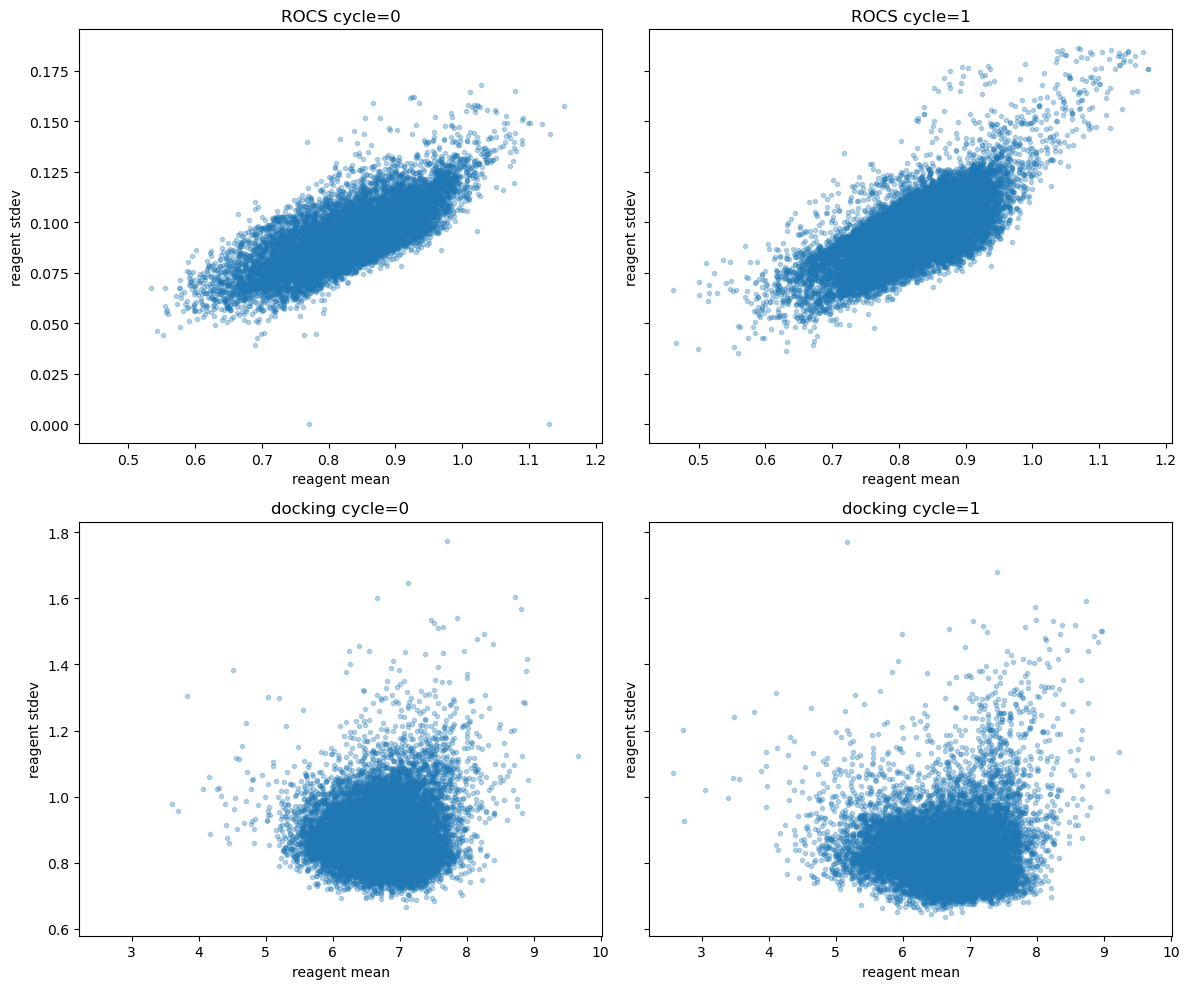

In [200]:
fig, axes = plt.subplots(2, 2, sharex="row", sharey="row", figsize=(12, 10))

def plot_stats(df_stats_reagents, axes, title):
    for (cycle, df), ax in zip(df_stats_reagents[df_stats_reagents["count"] > 0].groupby("cycle"), axes):
        ax.scatter(df["mean"], df["stdev"], alpha=0.3, marker=".")
        #ax.hexbin(df["mean"], df["stdev"])
        ax.set_xlabel("reagent mean")
        ax.set_ylabel("reagent stdev")
        ax.set_title(f"{title} {cycle=}")

plot_stats(df_stats_reagents_rocs, axes[0, :], "ROCS")
plot_stats(df_stats_reagents_docking, axes[1, :], "docking")
fig.tight_layout()

This an interesting difference in the shapes, with ROCS have a more clear "higher mean is higher standard deviation".

However, we need to get things into a better scale for easier interpretation. The natural thing is to center the data with 0 mean and stdeve 1. So the stdev axis because a relative standard deviation (relative to the stdev in the data).

In [202]:
def standardize(df_stats_reagents, stats):
    df = df_stats_reagents[df_stats_reagents["count"] > 0].copy()
    std = stats.stdev()
    mean = stats.mean()
    df["mean_std"] = (df["mean"] - mean) / std
    df["stdev_std"] = df["stdev"] / std
    df["min_std"] = (df["min"] - mean) / std
    df["max_std"] = (df["max"] - mean) / std
    return df

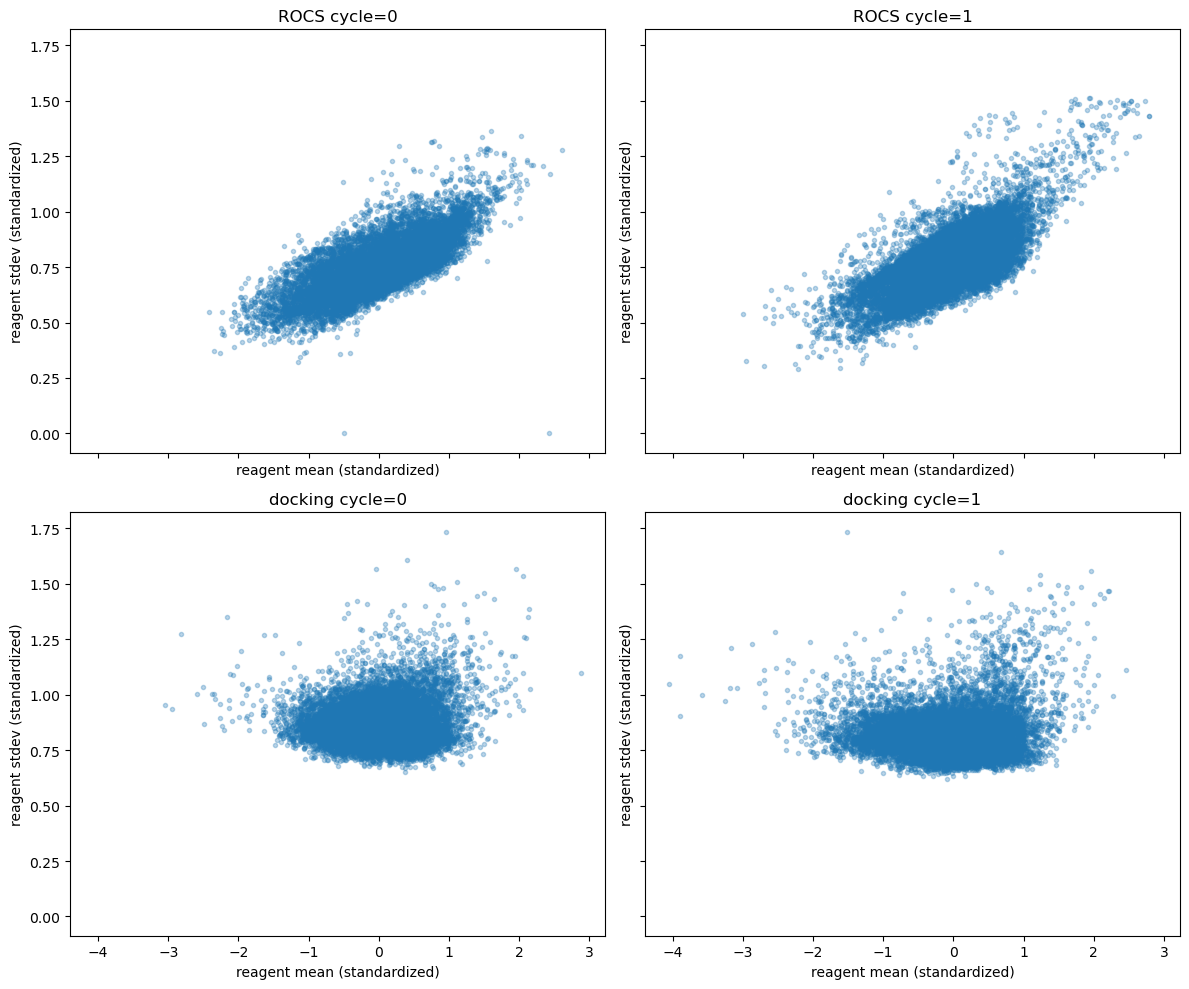

In [203]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 10))

def plot_stats(df_stats_reagents, stats, axes, title):
    df_stand = standardize(df_stats_reagents, stats)
    for (cycle, df), ax in zip(df_stand.groupby("cycle"), axes):
        ax.scatter(df["mean_std"], df["stdev_std"], alpha=0.3, marker=".")
        #ax.hexbin(df["mean"], df["stdev"])
        ax.set_xlabel("reagent mean (standardized)")
        ax.set_ylabel("reagent stdev (standardized)")
        #ax.set_ylim(0, None)
        ax.set_title(f"{title} {cycle=}")

plot_stats(df_stats_reagents_rocs, stats_rocs, axes[0, :], "ROCS")
plot_stats(df_stats_reagents_docking, stats_docking, axes[1, :], "docking")
fig.tight_layout()

Notably, the standard deviations are just higher for docking and there is not a clear association between mean and standard deviation.

This already suggest that docking may be a harder problem.

Of course, we actually care about the best stuff (even though TS tries to maximize the mean)

So how to the max of each reagents look compared to the mean?

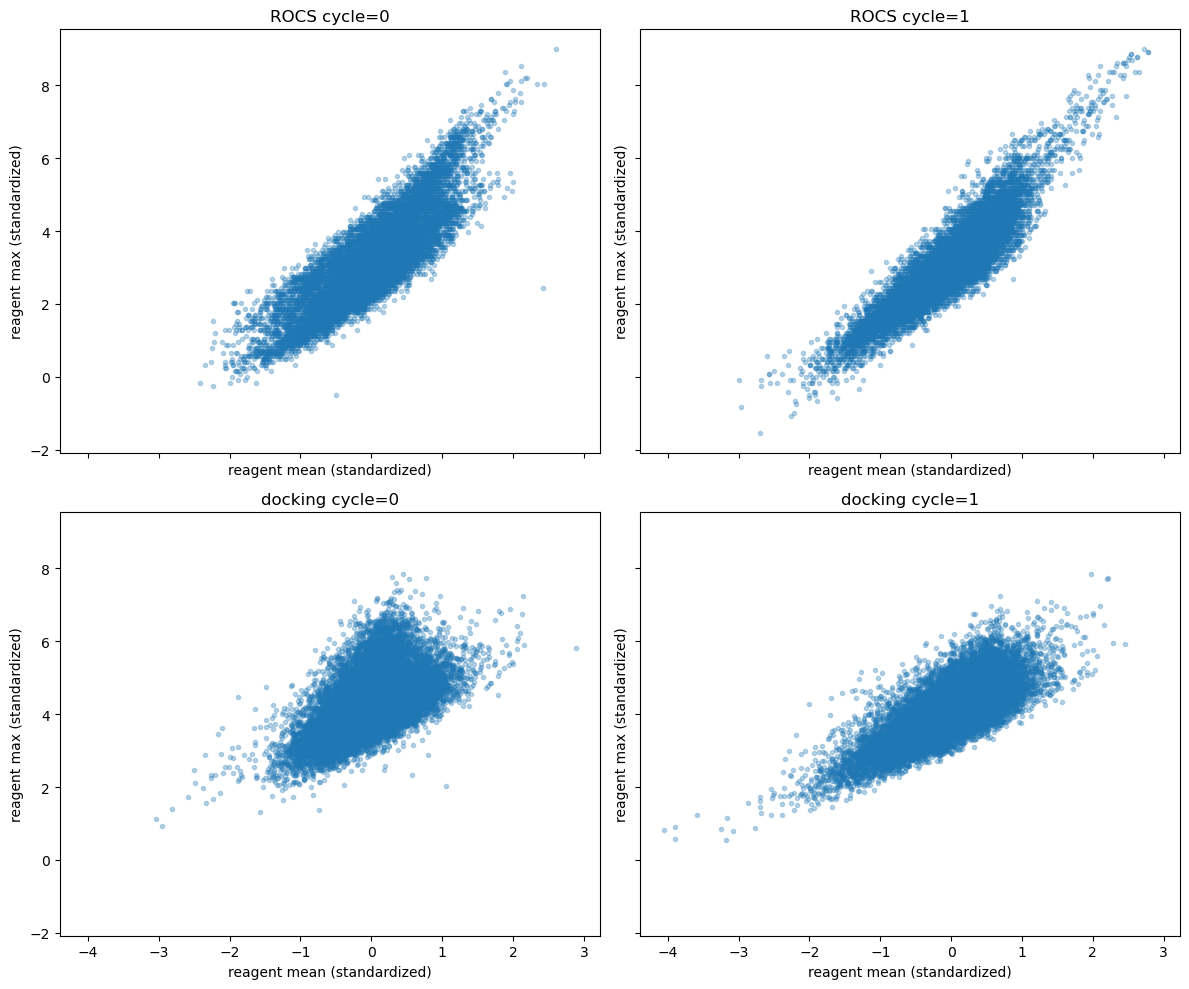

In [204]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 10))

def plot_stats(df_stats_reagents, stats, axes, title):
    df_stand = standardize(df_stats_reagents, stats)
    for (cycle, df), ax in zip(df_stand.groupby("cycle"), axes):
        ax.scatter(df["mean_std"], df["max_std"], alpha=0.3, marker=".")
        #ax.hexbin(df["mean"], df["stdev"])
        ax.set_xlabel("reagent mean (standardized)")
        ax.set_ylabel("reagent max (standardized)")
        #ax.set_ylim(0, None)
        ax.set_title(f"{title} {cycle=}")

plot_stats(df_stats_reagents_rocs, stats_rocs, axes[0, :], "ROCS")
plot_stats(df_stats_reagents_docking, stats_docking, axes[1, :], "docking")
fig.tight_layout()

Here, we have an even more clear issue! 

ROCS is clearly "Picking the reagents with the highest mean will give you the maximum reagent values"

Docking is much less like that and especially bad at cycle 0. In fact, we need to choose a bunch of reagents in cycle 0 that have near 0 (standardized) mean in order to get the highest value compounds. This will be challenging for TS to do.

Okay, a little caveat to that statement. Because we are doing TS optimziation on both cycles simulataneously, we don't acutally observe the mean/standard deviation here. We observe a mean/standard deviation for the biased choices in the other cycle. We could get some nice interaction between those simulataneous optimizations that makes it easier then it looks here. 

## Plot with the top reagents marked

Let's make the same plots, but color the points red when they are part of the top N molecules.

In [206]:
df_stats_reagents_rocs.sample(3)

,reaction,cycle,reagent,count,nan_count,mean,stdev,min,max
24846,m_22bbh,1,6107714,14095,0,0.936962,0.125177,0.46,1.47
30922,m_22bbh,1,508508,9604,0,0.752034,0.083025,0.50,1.06
13600,m_22bbh,0,2678240,14287,0,0.678900,0.050918,0.45,0.93


In [215]:
def add_top_cols(df_stats_reagents, top):
    for n in [10, 100, 500, 1000]:
        col = f"top{n}"
        df_stats_reagents[col] = False
        for mol in [mol for _, mol in top[:n]]:
            reac, reagents = parse_mol(mol)
            for cycle, reagent in enumerate(reagents):
                df_stats_reagents.loc[
                    (df_stats_reagents["reaction"] == reac) &
                    (df_stats_reagents["cycle"] == cycle) &
                    (df_stats_reagents["reagent"] == reagent),
                    col] = True
add_top_cols(df_stats_reagents_rocs, top_rocs)
add_top_cols(df_stats_reagents_docking, top_docking)

In [220]:
display(df_stats_reagents_rocs.sample(3))
display(df_stats_reagents_docking.sample(3))

,reaction,cycle,reagent,count,nan_count,mean,stdev,min,max,top10,top100,top500,top1000
20581,m_22bbh,1,12212284,14093,0,0.844015,0.090373,0.52,1.18,False,False,False,False
28196,m_22bbh,1,21990868,14095,0,0.882968,0.111273,0.43,1.32,False,False,False,False
23411,m_22bbh,1,13449230,13944,0,0.855841,0.101413,0.46,1.29,False,False,False,False


,reaction,cycle,reagent,count,nan_count,mean,stdev,min,max,top10,top100,top500,top1000
4402,m_22bba,0,5125844,18801,27,7.646727,0.847146,1.93,11.58,False,False,False,False
31269,m_22bba,1,14579974,17548,3,6.252960,0.851864,2.50,10.49,False,False,False,False
30679,m_22bba,1,6821768,17558,3,5.839052,0.875716,2.58,10.56,False,False,False,False


In [216]:
df_stats_reagents_rocs.groupby("cycle")[["top10", "top100", "top500", "top1000"]].sum()

,top10,top100,top500,top1000
cycle,,,,
0,1,11,38,63
1,10,35,77,91


In [218]:
top_rocs[:10]

[(1.94, 'm_22bbh_9285796_9705422'),
 (1.93, 'm_22bbh_9285796_581944'),
 (1.93, 'm_22bbh_9285796_15771828'),
 (1.92, 'm_22bbh_9285796_9600292'),
 (1.92, 'm_22bbh_9285796_134453'),
 (1.91, 'm_22bbh_9285796_9705438'),
 (1.91, 'm_22bbh_9285796_6361394'),
 (1.91, 'm_22bbh_9285796_134455'),
 (1.9, 'm_22bbh_9285796_9650224'),
 (1.9, 'm_22bbh_9285796_134454')]

In [217]:
df_stats_reagents_docking.groupby("cycle")[["top10", "top100", "top500", "top1000"]].sum()

,top10,top100,top500,top1000
cycle,,,,
0,9,88,352,584
1,3,29,86,173


In [219]:
top_docking[:10]

[(14.73, 'm_22bba_10159670_8370892'),
 (14.66, 'm_22bba_13779608_8370892'),
 (14.62, 'm_22bba_9292552_60143'),
 (14.6, 'm_22bba_14048036_9043540'),
 (14.47, 'm_22bba_136368_8370892'),
 (14.46, 'm_22bba_13779608_9043540'),
 (14.3, 'm_22bba_58308_8370892'),
 (14.3, 'm_22bba_13608252_8370892'),
 (14.26, 'm_22bba_57734_8370892'),
 (14.23, 'm_22bba_11975618_8370892')]

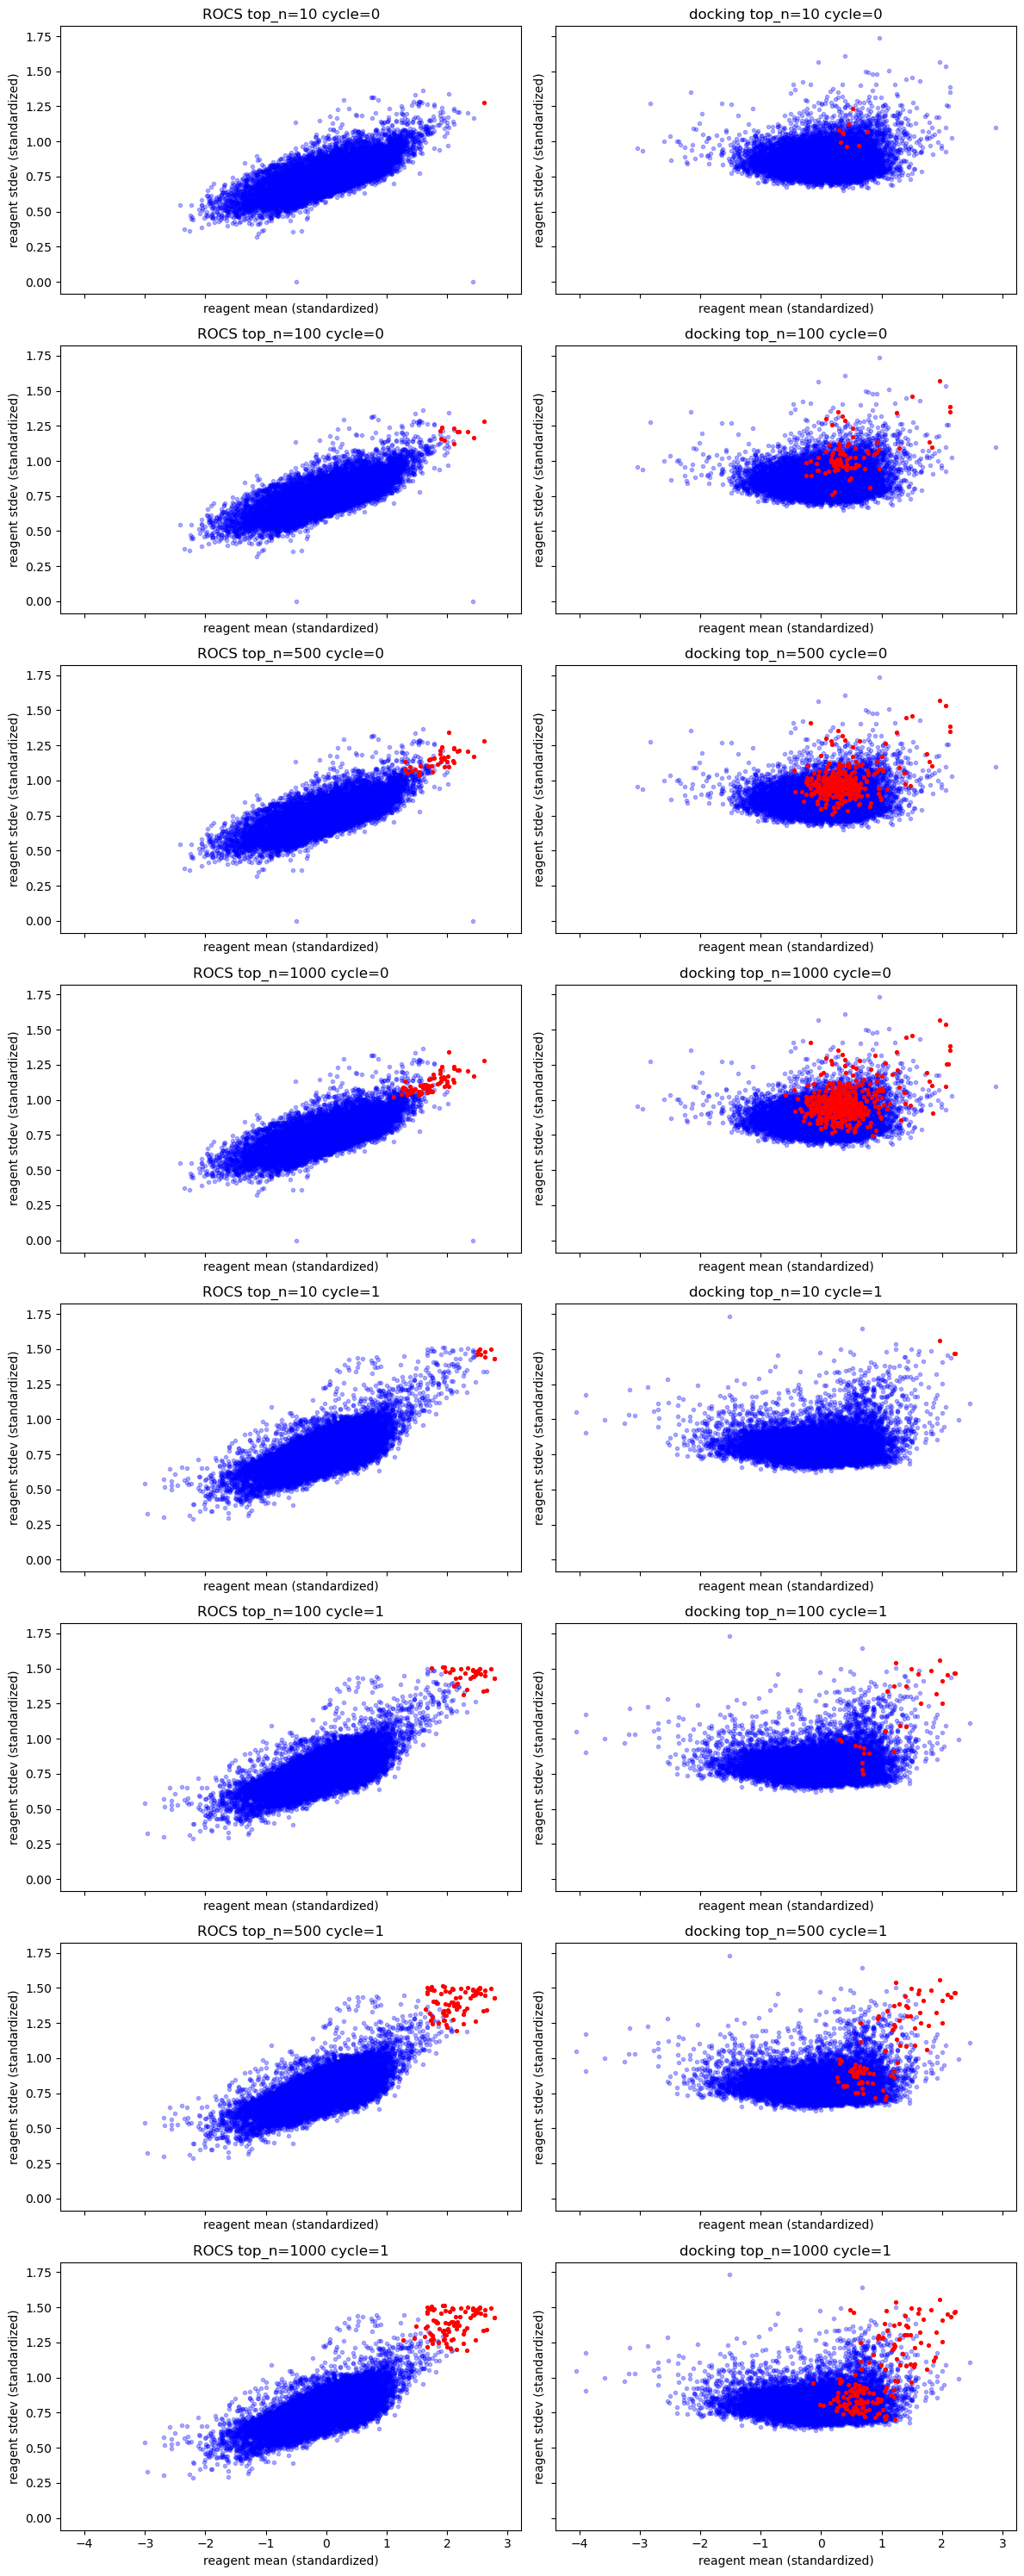

In [345]:
def plot_stats_with_top(df_stats_reagents, stats, cycle, top_n, ax, title):
    df_stand = standardize(df_stats_reagents, stats)
    df_filter = df_stand[df_stand["cycle"] == cycle]

    df = df_filter[~df_filter[f"top{top_n}"]]
    ax.scatter(df["mean_std"], df["stdev_std"], alpha=0.3, marker=".", color="b")
    df = df_filter[df_filter[f"top{top_n}"]]
    ax.scatter(df["mean_std"], df["stdev_std"], s=30, marker=".", color="r")
    
    #ax.hexbin(df["mean"], df["stdev"])
    ax.set_xlabel("reagent mean (standardized)")
    ax.set_ylabel("reagent stdev (standardized)")
    #ax.set_ylim(0, None)
    ax.set_title(f"{title} {top_n=} {cycle=}")

fig, axes = plt.subplots(8, 2, sharex=True, sharey=True, figsize=(12, 30))

for row_idx, (cycle, top_n) in enumerate(itertools.product([0, 1], [10, 100, 500, 1000])):
    plot_stats_with_top(df_stats_reagents_rocs, stats_rocs, cycle=cycle, top_n=top_n, ax=axes[row_idx, 0], title="ROCS")
    plot_stats_with_top(df_stats_reagents_docking, stats_docking, cycle=cycle, top_n=top_n, ax=axes[row_idx, 1], title="docking")
fig.tight_layout()

# Mathematical definition of the difficulty

If you are unsatsified with the squishines of the claim that the best reagents are "more mixed in" for docking and want some math to make that quantitative, this section is for you.

Imagine a Thompson Sampling like oracle. It knows, for every reagent $i$ in  cycle $c$, the true mean $\mu_{c,i}$ and true standard deviation $\sigma^2_{c,i}$. To select a molecule, the oracle samples from those distributions, and selects, for each cycle, the reagent with the max. Unlike our Thompson Sampling implementation, it has no memory so it could select the same reagents multiple times.

I believe the difficulty that this oracle would have finding the top molecules is a good quantitative operationalization of the "mixed in" insight above. If there is a reagent which is bad on average, but is wonderful when paired with the right reagent for the other cycle, that will be hard for the oracle to find. Note that the memoryless property of this oracle does make it *less* powerful than our true algorithm (which avoids making the same molecule multiple times), but, especially as a relative measure of difficulty, the orable still captures an essential challenge.

If you are reading this with the paper at your side, I'll apologize for a change of notation. In the paper we use $\mu_{i,t}$ to refer to the estimate of the mean of reagent $i$ at time $t$ in the algorithm and leave the cycle implicit. Here, we use $\mu_{c,i}$ to make the cycle explicit and don't need the time index.

There is a subtle difference in the sampling that this oracle does compared to a standard Thompson Sampling algorithm. This oracle is sampling for the distribution for the reagent

$$
X_{c,i} \sim N(\mu_{c,i}, \sigma^2_{c,i})
$$

where in Thompson Sampling, you sample from the belief distribution of the *mean*. In other words, the algorithm tries to pick the reagent with the best mean, ignoring the standard deviation of $X$ around that mean. Our oracle samples with the true standard deviation of the reagents. The oracle has no uncertainty around means, so there is no belief distribution to sample from.

For this oracle, let's define a random variable for the maximum of all other reagents besides $i$ for cycle $c$.

$$
M_{c,i} = \max_{j\neq i} X_{c,j}
$$

It's then trivial to define the probability that this oracle will select a particular reagent $i$ for cycle 0 and reagent $k$ for cycle 1.

$$
\displaylines{
P[X_{0,i} > M_{0,i}] P[X_{1,k} > M_{1,k}] \\
=
\left ( \int p[X_{0,i} = x] P[x > M_{0,i}] dx \right )
\left ( \int p[X_{1,k} = x] P[x > M_{1,k}] dx \right )
}
$$

You can approximate that intergral numerically (which we'll do by picking a discrete set of points), but what about that term $P[x > M_{0,i}]$ involving the CDF of a maximum of random variables?    
This turns out to be easy using a statistics fact I didn't believe when I first heard it (but it's trivial to derive): The CDF of the maximum of a set of random variable is just the product of the CDFs of all the variables. 
Why? In order for the maximum of a set to be smaller than a some value, each member of the set must be smaller than that value. In our notation:

$$
P[x > M_{0,i}] = \prod_{j\neq i} P[x > X_{0,j}]
$$

## Calculate the difficulty

In [405]:
def one_cycle_log_prob(df_cycle, reagent_dist, num_sigma=7, num_points=200):
    """Calculate the log probability of a specific reagent being picked for a component.

    df_cycle represents all the other reagents for that cycle (aka reaction component)
    reagent_dist represents the distribution of this reagent
    """
    #display(df_cycle)
    xs = np.linspace(reagent_dist.mean()[0] - reagent_dist.std()[0] * num_sigma,
                     reagent_dist.mean()[0] + reagent_dist.std()[0] * num_sigma,
                     num_points)

    numerator_terms = np.zeros(num_points)
    for row in df_cycle.itertuples(index=False):
        # I don't really know why we have these, but we'll just ignore them
        if row.stdev == 0.0:
            continue
        cdf_terms = scipy.stats.norm.logcdf(xs, loc=row.mean, scale=row.stdev)
        if np.any(np.isnan(cdf_terms)):
            print(f"Got NaN: {row.cycle=} {row.reagent=} {row.mean=}, {row.stdev=} idx={np.where(np.isnan(cdf_terms))}")
        else:
            numerator_terms += scipy.stats.norm.logcdf(xs, loc=row.mean, scale=row.stdev)    

    pdfs = reagent_dist.logpdf(xs)
    numerator_terms += pdfs
    denominator_terms = pdfs

    return scipy.special.logsumexp(numerator_terms) - scipy.special.logsumexp(denominator_terms)
    
def log_prob_selecting(df_stats_reagents, reagents):
    """Calculate teh log probability of the oracle pickign this molecule."""
    log_probs = []

    for cycle, reagent in enumerate(reagents):
        df = df_stats_reagents[
              (df_stats_reagents["cycle"] == cycle) & 
              (df_stats_reagents["reagent"] == reagent)]
        if len(df) != 1:
            raise ValueError("Bad Reagent {reagent}")
        #display(df)
        this_dist = scipy.stats.norm(loc=df["mean"], scale=df["stdev"])

        log_probs.append(one_cycle_log_prob(
            df_stats_reagents[(df_stats_reagents["cycle"] == cycle) & (df_stats_reagents["reagent"] != reagent)], this_dist))
        
    #print(log_probs)
    return log_probs, np.sum(log_probs)

In [380]:
top_rocs[0]

(1.94, 'm_22bbh_9285796_9705422')

In [381]:
df_stats_reagents_rocs[df_stats_reagents_rocs["reagent"] == 9285796]

,reaction,cycle,reagent,count,nan_count,mean,stdev,min,max,top10,top100,top500,top1000
2954,m_22bbh,0,9285796,16920,0,1.152322,0.157609,0.49,1.94,True,True,True,True


In [403]:
cycle_log_probs, log_prob = log_prob_selecting(df_stats_reagents_rocs, [9285796, 9705422])
print(cycle_log_probs)
np.exp(log_prob)

[-2.9283064270606283, -3.40257493953564]


0.0017804638360089057

That seems kinda reasonable. Let's try a middling compound.

In [368]:
df_stats_reagents_rocs.sample(10)

,reaction,cycle,reagent,count,nan_count,mean,stdev,min,max,top10,top100,top500,top1000
17623,m_22bbh,1,10477004,13504,0,0.885117,0.105451,0.45,1.32,False,False,False,False
3575,m_22bbh,0,10155668,15497,0,0.873756,0.091444,0.41,1.26,False,False,False,False
25905,m_22bbh,1,16484986,14083,0,0.816747,0.094062,0.48,1.21,False,False,False,False
18479,m_22bbh,1,21060812,14085,0,0.885871,0.091633,0.49,1.31,False,False,False,False
6538,m_22bbh,0,13613514,16918,0,0.936375,0.115605,0.44,1.59,False,False,False,False
26130,m_22bbh,1,16762628,13990,0,0.870008,0.080898,0.54,1.17,False,False,False,False
29165,m_22bbh,1,60072,14029,0,0.901296,0.102260,0.49,1.38,False,False,False,False
903,m_22bbh,0,6287252,12191,0,0.787893,0.061808,0.55,1.14,False,False,False,False
15632,m_22bbh,1,8990258,13104,0,0.877490,0.096678,0.48,1.29,False,False,False,False
23601,m_22bbh,1,13600810,13999,0,0.779144,0.099059,0.51,1.16,False,False,False,False


In [391]:
cycle_log_probs, log_prob = log_prob_selecting(df_stats_reagents_rocs, [13613514, 10477004])
print(cycle_log_probs)
np.exp(log_prob)

[-9.927174358892923, -17.087434377114953]


1.85227086313179e-12

This is showing some weird data for ROCS with reagents that only have a single value

In [363]:
df_stats_reagents_rocs[df_stats_reagents_rocs["reagent"].isin([57982, 13952426])]

,reaction,cycle,reagent,count,nan_count,mean,stdev,min,max,top10,top100,top500,top1000
5478,m_22bbh,0,57982,1,0,1.13,0.0,1.13,1.13,False,False,False,False
6886,m_22bbh,0,13952426,1,0,0.77,0.0,0.77,0.77,False,False,False,False


### Investigate convergence

We have a couple of empirical parameters of how many $\sigma$ to sample outward and how many points to sample. This section investigates what reasonable parameters are.

Let's take our middling case and see how some of the parameters affect things 

In [390]:
r0, r1 = [13613514, 10477004]
df = df_stats_reagents_rocs[
      (df_stats_reagents_rocs["cycle"] == 0) & 
      (df_stats_reagents_rocs["reagent"] == r0)]
this_dist = scipy.stats.norm(loc=df["mean"], scale=df["stdev"])
df_cycle0 = df_stats_reagents_rocs[(df_stats_reagents_rocs["cycle"] == 0) & (df_stats_reagents_rocs["reagent"] != r0)]
one_cycle_log_prob(df_cycle0, this_dist)

-9.927174358892923

In [401]:
data = []
for num_points in [10, 50, 100, 200, 350, 500, 750, 1000]:
    data.append((num_points, one_cycle_log_prob(df_cycle0, this_dist, num_points=num_points, num_sigma=6)))
df_points_converge = pd.DataFrame(data, columns=["num_points", "cycle0_log_prob"])
df_points_converge["exp_rounds"] = 1/np.exp(df_points_converge["cycle0_log_prob"])
df_points_converge

,num_points,cycle0_log_prob,exp_rounds
0,10,-10.538913,37756.497005
1,50,-9.927164,20479.171586
2,100,-9.927169,20479.285891
3,200,-9.927172,20479.349248
4,350,-9.927174,20479.379001
5,500,-9.927174,20479.391338
6,750,-9.927175,20479.401105
7,1000,-9.927175,20479.406044


In [397]:
data = []
for num_sigma in [3, 4, 5, 6, 7, 8]:
    data.append((num_sigma, one_cycle_log_prob(df_cycle0, this_dist, num_sigma=num_sigma, num_points=350)))
df_points_converge = pd.DataFrame(data, columns=["num_sigma", "cycle0_log_prob"])
df_points_converge["exp_rounds"] = 1/np.exp(df_points_converge["cycle0_log_prob"])
df_points_converge

,num_sigma,cycle0_log_prob,exp_rounds
0,3,-18.376552,9.568305e+07
1,4,-10.343279,3.104767e+04
2,5,-9.932333,2.058530e+04
3,6,-9.927174,2.047938e+04
4,7,-9.927156,2.047901e+04
5,8,-9.927156,2.047901e+04


In [398]:
data = []
for num_points in [10, 50, 100, 200, 350, 500, 750, 1000]:
    data.append((num_points, one_cycle_log_prob(df_cycle0, this_dist, num_points=num_points, num_sigma=7)))
df_points_converge = pd.DataFrame(data, columns=["num_points", "cycle0_log_prob"])
df_points_converge["exp_rounds"] = 1/np.exp(df_points_converge["cycle0_log_prob"])
df_points_converge

,num_points,cycle0_log_prob,exp_rounds
0,10,-9.332868,11303.500350
1,50,-9.927170,20479.310338
2,100,-9.927156,20479.009125
3,200,-9.927156,20479.009228
4,350,-9.927156,20479.009278
5,500,-9.927156,20479.009300
6,750,-9.927156,20479.009317
7,1000,-9.927156,20479.009325


In [400]:
data = []
for num_points, num_sigma in [(100, 5), (150, 6), (200, 7), (400, 8)]:
    data.append((num_points, num_sigma, one_cycle_log_prob(df_cycle0, this_dist, num_points=num_points, num_sigma=num_sigma)))
df_points_converge = pd.DataFrame(data, columns=["num_points", "num_sigma", "cycle0_log_prob"])
df_points_converge["exp_rounds"] = 1/np.exp(df_points_converge["cycle0_log_prob"])
df_points_converge

,num_points,num_sigma,cycle0_log_prob,exp_rounds
0,100,5,-9.931419,20566.499649
1,150,6,-9.927171,20479.327186
2,200,7,-9.927156,20479.009228
3,400,8,-9.927156,20479.008815


This looks like 200/7 is a pretty good. Let's check in on our top reagent to be sure.

In [402]:
r0, r1 = [9285796, 9705422]
df = df_stats_reagents_rocs[
      (df_stats_reagents_rocs["cycle"] == 0) & 
      (df_stats_reagents_rocs["reagent"] == r0)]
this_dist_top = scipy.stats.norm(loc=df["mean"], scale=df["stdev"])
df_cycle0_top = df_stats_reagents_rocs[(df_stats_reagents_rocs["cycle"] == 0) & (df_stats_reagents_rocs["reagent"] != r0)]
one_cycle_log_prob(df_cycle0_top, this_dist_top)

-2.9283064270606283

In [404]:
data = []
for num_points, num_sigma in itertools.product([100, 200, 300, 400], [5, 6, 7, 8]):
    data.append((num_points, num_sigma, one_cycle_log_prob(df_cycle0_top, this_dist_top, num_points=num_points, num_sigma=num_sigma)))
df_points_converge = pd.DataFrame(data, columns=["num_points", "num_sigma", "cycle0_log_prob"])
df_points_converge["exp_rounds"] = 1/np.exp(df_points_converge["cycle0_log_prob"])
df_points_converge

,num_points,num_sigma,cycle0_log_prob,exp_rounds
0,100,5,-2.928310,18.696008
1,100,6,-2.928306,18.695941
2,100,7,-2.928306,18.695940
3,100,8,-2.928306,18.695940
4,200,5,-2.928311,18.696019
5,200,6,-2.928306,18.695941
6,200,7,-2.928306,18.695940
7,200,8,-2.928306,18.695940
8,300,5,-2.928311,18.696022
9,300,6,-2.928306,18.695941


Unsurprisingly, this is actually a lot easier to converge. Let's declare success with 200/7 and I am updating the defaults in the code above.

### Finally the real calculation and plots

Now we'll go through and calculate the probability of selecting each of the top reagents for ROCS and docking.

In [385]:
from tqdm.notebook import trange, tqdm
def compute_top_sel_probs(top, df_stats_reagents):
    data = []
    for i in trange(len(top)):
        score, mol = top[i]
        reaction, reagents = parse_mol(mol)
        cycle_log_probs, log_prob = log_prob_selecting(df_stats_reagents, reagents)
        data.append((reaction, reagents[0], reagents[1], score, cycle_log_probs[0], cycle_log_probs[1], log_prob))
    return pd.DataFrame(data, columns=["reaction", "reagent0", "reagent1", "score", "cycle0_log_prob", "cycle1_log_prob", "log_prob_sel"])

In [406]:
df_top_rocs = compute_top_sel_probs(top_rocs, df_stats_reagents_rocs)
df_top_rocs.sample(5)

  0%|          | 0/1000 [00:00<?, ?it/s]

,reaction,reagent0,reagent1,score,cycle0_log_prob,cycle1_log_prob,log_prob_sel
325,m_22bbh,9099844,12625124,1.74,-3.861066,-4.565018,-8.426084
519,m_22bbh,14471772,9705422,1.72,-3.983817,-3.402575,-7.386392
640,m_22bbh,14421402,134455,1.71,-5.062820,-3.698697,-8.761517
184,m_22bbh,9099844,136823,1.77,-3.861066,-4.143636,-8.004702
633,m_22bbh,14471772,9229000,1.71,-3.983817,-4.404706,-8.388523


In [407]:
df_top_docking = compute_top_sel_probs(top_docking, df_stats_reagents_docking)
df_top_docking.sample(5)

  0%|          | 0/1000 [00:00<?, ?it/s]

,reaction,reagent0,reagent1,score,cycle0_log_prob,cycle1_log_prob,log_prob_sel
136,m_22bba,2440458,8370892,13.42,-10.333568,-3.253717,-13.587285
507,m_22bba,9583246,60143,13.06,-14.475905,-3.122082,-17.597987
76,m_22bba,6283224,60143,13.59,-11.001498,-3.122082,-14.123580
728,m_22bba,14048372,60142,12.94,-10.786774,-4.080477,-14.867251
963,m_22bba,14483322,17053832,12.85,-3.373532,-15.844929,-19.218461


In [408]:
df_top_rocs.to_csv(f"{DATA_DIR}/top_rocs_processed.csv", index=False)
!head {DATA_DIR}/top_rocs_processed.csv
df_top_docking.to_csv(f"{DATA_DIR}/top_docking_processed.csv", index=False)
!head {DATA_DIR}/top_docking_processed.csv

reaction,reagent0,reagent1,score,cycle0_log_prob,cycle1_log_prob,log_prob_sel
m_22bbh,9285796,9705422,1.94,-2.92830641179549,-3.40257491389736,-6.33088132569285
m_22bbh,9285796,581944,1.93,-2.92830641179549,-3.4933970916971426,-6.421703503492632
m_22bbh,9285796,15771828,1.93,-2.92830641179549,-3.4872936261664247,-6.415600037961914
m_22bbh,9285796,9600292,1.92,-2.92830641179549,-3.6768696441783004,-6.60517605597379
m_22bbh,9285796,134453,1.92,-2.92830641179549,-3.679609241296195,-6.607915653091685
m_22bbh,9285796,9705438,1.91,-2.92830641179549,-3.59064171654466,-6.518948128340149
m_22bbh,9285796,6361394,1.91,-2.92830641179549,-3.7521203355301735,-6.680426747325663
m_22bbh,9285796,134455,1.91,-2.92830641179549,-3.6986968085588137,-6.627003220354304
m_22bbh,9285796,9650224,1.9,-2.92830641179549,-3.755617663337003,-6.683924075132493
reaction,reagent0,reagent1,score,cycle0_log_prob,cycle1_log_prob,log_prob_sel
m_22bba,10159670,8370892,14.73,-8.662329879537328,-3.2537174654152903,-11.9160473

(-2.0, 201.0)

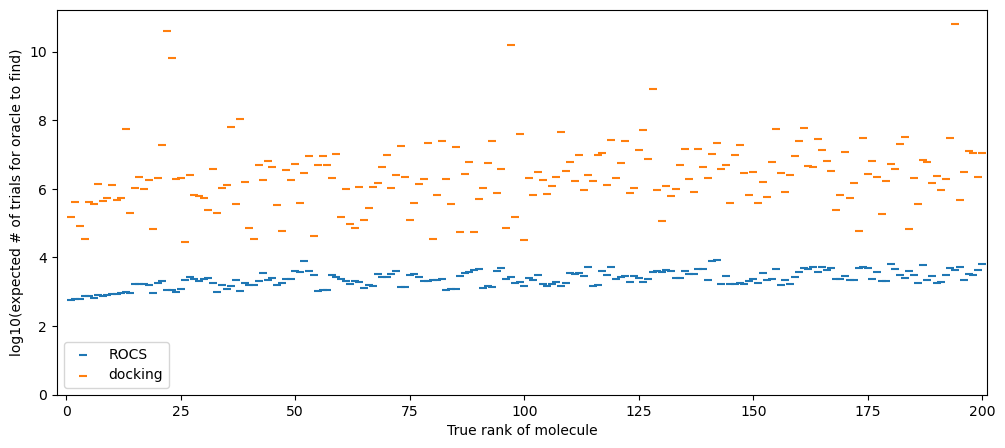

In [419]:
n_to_plot = 200
fig, ax = plt.subplots(figsize=(12, 5))

def plot(df, label):
    ax.scatter(range(1, n_to_plot+1), -df.head(n_to_plot)["log_prob_sel"] / np.log(10), marker="_", label=label)
plot(df_top_rocs, "ROCS")
plot(df_top_docking, "docking")

ax.legend()
ax.set_xlabel("True rank of molecule")
ax.set_ylabel("log10(expected # of trials for oracle to find)")
ax.set_ylim(0, None)
ax.set_xlim(-2, n_to_plot+1)